In [4]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
torch.set_default_dtype(torch.float32)
from flumen import CausalFlowModel,TrunkNet, TrajectoryDataset
from flumen.utils import pack_model_inputs, plot_amari, trajectory,plot_space_time_flat_trajectory_V2
from torch.utils.data import DataLoader

from generate_data import make_trajectory_sampler

from argparse import ArgumentParser

import yaml
from pathlib import Path
import sys
from pprint import pprint
from time import time
import os
os.chdir("C:/Users/20192139/Documents/5ARG45 - Thesis/Code/FlowFunction/flumen")  # Change this to your actual path
import wandb
import pickle
from flumen import CausalFlowModel, print_gpu_info, TrajectoryDataset, TrunkNet
import torch
import torch.nn as nn


## Plotting functions

In [64]:

def plot_trajectory_multiple_trajectories(
    y, y_pred_list, t_feed,
    labels=None,
    time_indices=[10, 50, 100],
    space_indices=[25, 50, 75]
):
    '''
    y: ground truth tensor of shape (nt, nx)
    y_pred_list: list of predicted tensors, each of shape (nt, nx)
    t_feed: time tensor (nt,)
    labels: list of labels corresponding to [y, *y_pred_list]
    '''

    # === Plot style ===
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 16
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['legend.fontsize'] = 12
    mpl.rcParams['font.size'] = 16
    mpl.rcParams['axes.grid'] = True
    mpl.rcParams['grid.linestyle'] = '-'
    mpl.rcParams['grid.alpha'] = 0.7
    mpl.rcParams['lines.linewidth'] = 1.5
    mpl.rcParams['figure.figsize'] = [20, 6]

    colors = ["black", "#0072BD", "#D95319", "#77AC30", "#7E2F8E"]
    linestyles = ['-', '--', ':', '-.', '-']
    
    # Prepare time
    t_feed = torch.flip(t_feed.view(-1), dims=[0])
    y_np = y.detach().cpu().numpy().T  # (nx, nt)

    # Flip predictions and convert to numpy
    y_pred_np_list = [torch.flip(pred, dims=[0]).detach().cpu().numpy().T for pred in y_pred_list]

    # All data for consistent y-axis
    all_data = [y_np] + y_pred_np_list
    global_min = min(arr.min() for arr in all_data)
    global_max = max(arr.max() for arr in all_data)

    x = np.linspace(0, 25, y.shape[1])  # spatial coordinate

    num_times = len(time_indices)
    num_space = len(space_indices)
    n_cols = max(4, num_times)
    n_rows = 2

    fig = plt.figure(dpi=100)
    gs = fig.add_gridspec(n_rows, n_cols)

    # === Plot over space for selected times ===
    for i, t in enumerate(time_indices):
        ax = fig.add_subplot(gs[0, i])
        ax.plot(x, y_np[:, t], label=labels[0], color=colors[0], linestyle=linestyles[0])
        for j, y_pred_np in enumerate(y_pred_np_list):
            ax.plot(x, y_pred_np[:, t], label=labels[j + 1], color=colors[j + 1], linestyle=linestyles[(j + 1) % len(linestyles)])
        ax.set_ylim(global_min, global_max)
        ax.set_title(f"t = {t_feed[t]:.1f}")
        ax.set_xlabel("x")
        ax.set_ylabel("u(x)")
        ax.legend()
        ax.grid(True)

    # === Plot over time for selected spatial indices ===
    for i, idx in enumerate(space_indices):
        ax = fig.add_subplot(gs[1, i])
        ax.plot(t_feed, y_np[idx, :], label=labels[0], color=colors[0], linestyle=linestyles[0])
        for j, y_pred_np in enumerate(y_pred_np_list):
            ax.plot(t_feed, y_pred_np[idx, :], label=labels[j + 1], color=colors[j + 1], linestyle=linestyles[(j + 1) % len(linestyles)])
        ax.set_ylim(global_min, global_max)
        ax.set_title(f"x = {x[idx]:.1f}")
        ax.set_xlabel("t")
        ax.set_ylabel("u(t)")
        ax.legend()
        ax.grid(True)

    fig.tight_layout()
    return fig

In [65]:
def plot_trajectory(
    y, y_pred, t_feed,
    time_indices=[10, 50, 100],
    space_indices=[25, 50, 75]
):
    '''Returns:
       - Heatmaps: Ground truth, Prediction, Absolute Error.
       - Line plots over space at selected times.
       - Line plots over time at selected neurons.
       - Red dotted lines at selected neuron indices.
    '''

    # === Apply style settings ===
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams['axes.titlesize'] = 16
    mpl.rcParams['axes.labelsize'] = 16
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['legend.fontsize'] = 12
    mpl.rcParams['font.size'] = 16
    mpl.rcParams['axes.grid'] = True
    mpl.rcParams['grid.linestyle'] = '-'
    mpl.rcParams['grid.alpha'] = 0.7
    mpl.rcParams['lines.linewidth'] = 1.5
    colors = ["#0072BD", "#77AC30", "#D95319", "#7E2F8E", "#EDB120", "#4DBEEE", "#A2142F"]
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
    mpl.rcParams['figure.figsize'] = [20, 6]

    # === Begin plotting ===
    t_feed = torch.flip(t_feed.view(-1), dims=[0])
    y_pred = torch.flip(y_pred, dims=[0])

    x = np.linspace(0, 25, y.shape[1])  # x-axis (space), shape: (100,)
    y_np = y.detach().cpu().numpy().T      # shape: (neurons, time)
    y_pred_np = y_pred.detach().cpu().numpy().T
    error_np = np.abs(y_np - y_pred_np)

    global_min = min(y_np.min(), y_pred_np.min())
    global_max = max(y_np.max(), y_pred_np.max())

    num_times = len(time_indices)
    num_space = len(space_indices)
    n_cols = max(4, num_times)
    n_rows = 2

    fig = plt.figure(dpi=100)
    gs = fig.add_gridspec(n_rows, n_cols)

#     # --- Heatmaps ---
#     T = y_np.shape[1]
#     xticks = np.linspace(0, T - 1, num=6, dtype=int)
#     xtick_labels = np.linspace(0, 50, num=6)

#     S = y_np.shape[0]
#     yticks = np.linspace(0, S - 1, num=6, dtype=int)
#     ytick_labels = np.linspace(0, 25, num=6)

#     # Ground Truth
#     ax0 = fig.add_subplot(gs[0, 0:2])
#     im0 = ax0.imshow(y_np, aspect='auto', cmap='viridis', vmin=0, vmax=1)
#     ax0.set_title(r"$u(x,t)$")
#     ax0.set_xticks(xticks)
#     ax0.set_xticklabels([f"{val:.1f}" for val in xtick_labels])
#     ax0.set_xlabel("t")
#     ax0.set_yticks(yticks)
#     ax0.set_yticklabels([f"{val:.1f}" for val in ytick_labels])
#     ax0.set_ylabel("x")
#     plt.colorbar(im0, ax=ax0)

#     # Prediction
#     ax1 = fig.add_subplot(gs[0, 2:4])
#     im1 = ax1.imshow(y_pred_np, aspect='auto', cmap='viridis', vmin=0, vmax=1)
#     ax1.set_title(r"$u_{\text{pred}}(x,t)$")
#     ax1.set_xticks(xticks)
#     ax1.set_xticklabels([f"{val:.1f}" for val in xtick_labels])
#     ax1.set_xlabel("t")
#     ax1.set_yticks(yticks)
#     ax1.set_yticklabels([f"{val:.1f}" for val in ytick_labels])
#     ax1.set_ylabel("x")
#     plt.colorbar(im1, ax=ax1)

#     # Absolute Error
#     ax2 = fig.add_subplot(gs[0, 4:])
#     im2 = ax2.imshow(error_np, aspect='auto', cmap='viridis', vmin=0, vmax=1)
#     ax2.set_title(r"$|u(x,t) - u_{\text{pred}}(x,t)|$")
#     ax2.set_xticks(xticks)
#     ax2.set_xticklabels([f"{val:.1f}" for val in xtick_labels])
#     ax2.set_xlabel("t")
#     ax2.set_yticks(yticks)
#     ax2.set_yticklabels([f"{val:.1f}" for val in ytick_labels])
#     ax2.set_ylabel("x")
#     plt.colorbar(im2, ax=ax2)

    # --- Line plots over space at selected times ---
    for i, t in enumerate(time_indices):
        y_t = y_np[:, t]
        y_t_pred = y_pred_np[:, t]
        ax = fig.add_subplot(gs[0, i])
        ax.plot(x, y_t, label=r"$u(x)$", linestyle='--')
        ax.plot(x, y_t_pred, label=r"$u_{\text{pred}}(x)$", linestyle='-',color='#D95319')
        ax.set_ylim(global_min, global_max)
        ax.set_title(f"t = {t_feed[t]:.0f}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend()
        ax.grid(True)

    # --- Line plots over time at selected neurons ---
    for i, idx in enumerate(space_indices):
        y_idx = y_np[idx, :]
        y_pred_idx = y_pred_np[idx, :]
        ax = fig.add_subplot(gs[1, i])
        ax.plot(t_feed, y_idx, label=r"$u(t)$", linestyle='--')
        ax.plot(t_feed, y_pred_idx, label=r"$u_{\text{pred}}(t)$", linestyle='-',color='#D95319')
        ax.set_ylim(global_min, global_max)
        ax.set_title(f"x = {x[idx]:.0f}")
        ax.set_xlabel("t")
        ax.set_ylabel("y")
        ax.legend()
        ax.grid(True)

    fig.tight_layout()
    return fig

In [66]:
def plot_trajectory(
    y, y_pred,t_feed,
    time_indices=[0, 20, 40, 60, 80],
    space_indices=[0, 25, 50, 75,99]
):
    '''Returns:
       - Heatmaps: Ground truth, Prediction, Absolute Error.
       - Line plots over space at selected times.
       - Line plots over time at selected neurons.
       - Red dotted lines at selected neuron indices.
    '''
    t_feed = torch.flip(t_feed.view(-1), dims=[0])
    # Flip and convert tensors to numpy
    y_pred = torch.flip(y_pred, dims=[0])
    x = np.linspace(0, 25, y.shape[1])  # NumPy array of shape (100,)
    y_np = y.detach().cpu().numpy().T  # shape: (neurons, time)
    y_pred_np = y_pred.detach().cpu().numpy().T
    error_np = np.abs(y_np - y_pred_np)
#     l1_loss = nn.L1Loss(y.cpu(), y_pred.cpu()).item()

    # Determine global y-limits
    global_min = min(y_np.min(), y_pred_np.min())
    global_max = max(y_np.max(), y_pred_np.max())

    num_times = len(time_indices)
    num_space = len(space_indices)
    n_cols = max(4, num_times)
    n_rows = 3

    fig = plt.figure(figsize=(3 * n_cols, 7), dpi=100)
    gs = fig.add_gridspec(n_rows, n_cols)

    # --- Heatmaps ---

    # Ground Truth
    T = y_np.shape[1]
    xticks = np.linspace(0, T - 1, num=6, dtype=int)  # positions in array
    xtick_labels = np.linspace(0, 50, num=6)          # labels from 0 to 50

    ax0 = fig.add_subplot(gs[0, 0:2])
    im0 = ax0.imshow(y_np, aspect='auto', cmap='viridis', vmin=0, vmax=1)
    ax0.set_title(r"$u(x,t)$")
    ax0.set_xticks(xticks)
    ax0.set_xticklabels([f"{x:.1f}" for x in xtick_labels])
    ax0.set_xlabel("t")
    S = y_np.shape[0]  # number of spatial points (rows)
    yticks = np.linspace(0, S - 1, num=6, dtype=int)        # row positions
    ytick_labels = np.linspace(0, 25, num=6)                # labels from 0 to 25

    ax0.set_yticks(yticks)
    ax0.set_yticklabels([f"{y:.1f}" for y in ytick_labels])
    ax0.set_ylabel("x")
    plt.colorbar(im0, ax=ax0)
#     for t in time_indices:
#         ax0.axvline(x=t, color='red', linestyle='--')
#     for s in space_indices:
#         ax0.axhline(y=s, color='red', linestyle=':')

    # Prediction
    ax1 = fig.add_subplot(gs[0, 2:4])
    im1 = ax1.imshow(y_pred_np, aspect='auto', cmap='viridis', vmin=0, vmax=1)
    ax1.set_title(r"$u_{\text{pred}}(x,t)$")
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([f"{x:.1f}" for x in xtick_labels])
    ax1.set_xlabel("t")
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([f"{y:.1f}" for y in ytick_labels])
    ax1.set_ylabel("x")
    plt.colorbar(im1, ax=ax1)
#     for t in time_indices:
#         ax1.axvline(x=t, color='red', linestyle='--')
#     for s in space_indices:
#         ax1.axhline(y=s, color='red', linestyle=':')

    # Absolute Error (Same colormap)
    ax2 = fig.add_subplot(gs[0, 4:])
    im2 = ax2.imshow(error_np, aspect='auto', cmap='viridis', vmin=0, vmax=1)
    ax2.set_title(r"$|u(x,t)-u_{\text{pred}}(x,t)|$")
    plt.colorbar(im2, ax=ax2)
#     for t in time_indices:
#         ax2.axvline(x=t, color='blue', linestyle='--')
#     for s in space_indices:
#         ax2.axhline(y=s, color='red', linestyle=':')

    # --- Line plots over space at selected times ---
    for i, t in enumerate(time_indices):
        y_t = y_np[:, t]
        y_t_pred = y_pred_np[:, t]
        L1_loss_t = np.mean(np.abs(y_t - y_t_pred))
        L2_loss_t = np.mean((y_t - y_t_pred) ** 2)
        ax = fig.add_subplot(gs[1, i])
        ax.plot(x,y_t, label=r"$u(x)$", linestyle='--', color='b')
        ax.plot(x,y_t_pred, label=r"$u_{\text{pred}}(x)$", linestyle='-', color='r')
        ax.set_ylim(global_min, global_max)
        ax.set_title(f"t={t_feed[t]:.1f}")
        ax.set_xlabel("x")
        ax.set_ylabel("Activation")
        ax.legend()
        ax.grid(True)

    # --- Line plots over time at selected neurons ---
    x
    for i, idx in enumerate(space_indices):
        y_idx = y_np[idx, :]
        y_pred_idx = y_pred_np[idx, :]
        l1_loss_neuron = np.mean(np.abs(y_idx - y_pred_idx))
        ax = fig.add_subplot(gs[2, i])
        ax.plot(t_feed,y_idx, label=r"$u(t)$", linestyle='--', color='b')
        ax.plot(t_feed,y_pred_idx, label=r"$u_{\text{pred}}(t)$", linestyle='-', color='r')
        ax.set_ylim(global_min, global_max)
        ax.set_title(f"x={x[idx]:.1f}")
        ax.set_xlabel("t")
        ax.set_ylabel("Activation")
        ax.legend()
        ax.grid(True)
    fig.tight_layout()
    return fig



## Load in Model

In [67]:
def return_model(path):
    api = wandb.Api()
    model_artifact = api.artifact(path)
    model_path = Path(model_artifact.download())
    model_run = model_artifact.logged_by()
    print(model_run.summary)
    # print(model_run.summary)
    device = "cpu"
    # Load model state dictionary
    with open(model_path / "state_dict.pth", 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device("cpu"))  # Ensure compatibility

    with open(model_path / "metadata.yaml", 'r') as f:
        metadata: dict = yaml.load(f, Loader=yaml.FullLoader)
    # pprint(metadata)
    # print(metadata["args"])
    trunk_model = TrunkNet(in_size=256,out_size=100,hidden_size=metadata['args']['trunk_size_svd'],use_batch_norm=False)

    model = CausalFlowModel(**metadata["args"],trunk_model=trunk_model)
    model.load_state_dict(state_dict)
    model.eval()
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    return model

model_T2500 = return_model("marijn-eindhoven-university-of-technology/mu_2/flow_model-brian2_mexhat_T2500-A_Nonlinear_100_L1:v65")
model_T100_Scratch = return_model("marijn-eindhoven-university-of-technology/mu_1/flow_model-brian2_mexhat_T100-Scratch_T100_A_Nonlinear_100_L1:v23")
model_T100_oscillatory = return_model("marijn-eindhoven-university-of-technology/mu_1/flow_model-brian2_mexhat_T100-T90_mu3:v11")
model_T100_guassian = return_model("marijn-eindhoven-university-of-technology/mu_3/flow_model-brian2_oscillatory_T100-T90_mu1:v16")

wandb:   2 of 2 files downloaded.  


True
{'Flownet/Best_epoch': 151, 'Flownet/Test trajectory': {'_type': 'image-file', 'format': 'png', 'height': 700, 'path': 'media/images/Flownet/Test trajectory_215_e89cf60757df6883f8b4.png', 'sha256': 'e89cf60757df6883f8b4e2601c74c7ca6b0e2819827a0fdfc13ed0b2c8745142', 'size': 225824, 'width': 1500}, 'Flownet/best_epoch': 151, 'Flownet/best_test': 0.026353112471443188, 'Flownet/best_train': 0.019568186268053827, 'Flownet/best_val': 0.025659444174858964, 'Flownet/epoch': 181, 'Flownet/lr': 2.8354712161078362e-08, 'Flownet/test_loss': 0.02634348890072183, 'Flownet/time': 20501.10050559044, 'Flownet/train_loss': 0.01956339791110504, 'Flownet/train_loss_data': 0.01956339791110504, 'Flownet/val_loss': 0.02570636580356314, '_runtime': 20690.437938517, '_step': 246, '_timestamp': 1754792684.851927, '_wandb': {'runtime': 20690}}


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_31776\1096230477.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch

Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
{'Flownet/Best_epoch': 60, 'Flownet/Test trajectory': {'_type': 'image-file', 'format': 'png', 'height': 700, 'path': 'media/images/Flownet/Test trajectory_82_76c11329a8be5b7659fe.png', 'sha256': '76c11329a8be5b7659fe1d3ced71b1f42bcf2e7fbde1346de7e032ef47d287cc', 'size': 255887, 'width': 1500}, 'Flownet/best_epoch': 60, 'Flownet/best_test': 0.07427221536636353, 'Flownet/best_train': 0.044990767843109354, 'Flownet/best_val': 0.0756499725393951, 'Flownet/epoch': 90, 'Flownet/lr': 9.073507891545076e-07, 'Flownet/test_loss': 0.07415965152904391, 'Flownet/time': 504.80629086494446, 'Flownet/train_loss': 0.043902392432472175, 'Flownet/train_loss_data': 0.043902392432472175, 'Flownet/val_loss': 0.07625281135551631, '_runtime': 521.075042615, '_step': 113, '_timestamp': 1754828857.4477768, '_wandb': {'runtime': 521}}
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
{'Flownet/Best_epoch': 25, 'Flownet/Test trajectory': {'_type': 'image-file', 'format': 'png', 'height': 700, 'path': 'media/images/Flownet/Test trajectory_37_1b4340cc7d8f825ee188.png', 'sha256': '1b4340cc7d8f825ee188d72603e859f8493a53ea4769c4628dc2700ea1e8da69', 'size': 239944, 'width': 1500}, 'Flownet/best_epoch': 25, 'Flownet/best_test': 0.03482888359576464, 'Flownet/best_train': 0.018937100255808043, 'Flownet/best_val': 0.03247224344522692, 'Flownet/epoch': 55, 'Flownet/lr': 3.125e-07, 'Flownet/test_loss': 0.0346595803857781, 'Flownet/time': 448.6927194595337, 'Flownet/train_loss': 0.017435422335143034, 'Flownet/train_loss_data': 0.017435422335143034, 'Flownet/val_loss': 0.03261515058693476, '_runtime': 460.843984626, '_step': 68, '_timestamp': 1754831680.8304904, '_wandb': {'runtime': 460}}
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
{'Flownet/Best_epoch': 17, 'Flownet/Test trajectory': {'_type': 'image-file', 'format': 'png', 'height': 700, 'path': 'media/images/Flownet/Test trajectory_34_17ca9053f4a5c88c11b5.png', 'sha256': '17ca9053f4a5c88c11b5ca83b859df7e141bee5e1290a9726b07c59fba8bad46', 'size': 254752, 'width': 1500}, 'Flownet/best_epoch': 17, 'Flownet/best_test': 0.045697942725382745, 'Flownet/best_train': 0.038098213505107545, 'Flownet/best_val': 0.050431398558430374, 'Flownet/epoch': 47, 'Flownet/lr': 3.125e-07, 'Flownet/test_loss': 0.04660155507735908, 'Flownet/time': 407.7731792926788, 'Flownet/train_loss': 0.03332579224828006, 'Flownet/train_loss_data': 0.03194148988393001, 'Flownet/val_loss': 0.05102276231627911, '_runtime': 420.385638847, '_step': 65, '_timestamp': 1754775196.858919, '_wandb': {'runtime': 420}}
Total trainable parameters: 1066351


(100,)


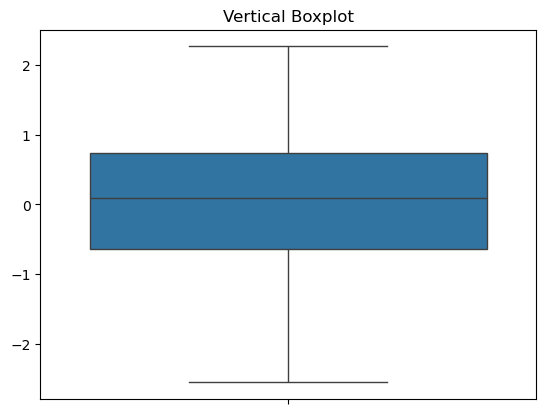

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example data
np.random.seed(0)
data = np.random.normal(loc=0, scale=1, size=100)
print(data.shape)
# Create boxplot

sns.boxplot(y=data)  # vertical boxplot
plt.title("Vertical Boxplot")
plt.show()

## Generate / load generated data

In [85]:
# with open('data_generation/brian2_gaussian.yaml', 'r') as f:
#         settings: dict = yaml.load(f, Loader=yaml.FullLoader)
# sampler = make_trajectory_sampler(settings)  
# time_horizon = 50 # [ms]
# n_samples = 200 # number of samples per trajectory
# x0_list = []
# t_list = []
# y_list = []
# u_list = []
# deltas_list = []
# # save 100 test trajectories
# for i in range(100):
#     x0, t, y, u,_ = sampler.get_example(time_horizon=50,n_samples=int(n_samples))
#     locations = torch.tensor(sampler._dyn.locations,dtype=torch.get_default_dtype())

#     x0_feed, t_feed, u_feed, deltas_feed = pack_model_inputs(
#             x0, t, u, sampler._dyn.delta)    
#     x0_list.append(x0_feed)
#     t_list.append(t_feed)
#     y_list.append(y)
#     u_list.append(u_feed)
#     deltas_list.append(deltas_feed)
# data = {
#     "x0": x0_list,
#     "t": t_list,
#     "y": y_list,
#     "u": u_list,
#     "deltas":deltas_list,
#     "locations":locations
# }

# # Save as a .pt file
# torch.save(data, "data/Brian2/gaussian_test.pt")

test_data = torch.load("data/Brian2/mexhat_test.pt")


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_31776\1044693220.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/mexhat_te

## Calculate Losses

In [69]:
trajectory_losses = []
for i in range(0,len(test_data['x0'])):
    with torch.no_grad():
        y = torch.tensor(test_data['y'][i])
        x0_feed = test_data['x0'][i]
        t_feed = test_data['t'][i]
        u_feed = test_data['u'][i]
        deltas_feed = test_data['deltas'][i]
        y_pred, basis_functions = model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
        test_loss_trajectory_over_space = torch.abs(y.to(device) - torch.flip(y_pred, dims=[0])).mean(dim=1)  # Or .mean(dim=1) for mean L1
        test_loss_trajectory_over_space_and_time = torch.mean(test_loss_trajectory_over_space)
        trajectory_losses.append(test_loss_trajectory_over_space_and_time)
#         if i == plot:
#             fig = plot_trajectory(y, y_pred,time_indices=[0, 20, 40, 60, 80],space_indices=[0, 25, 50, 75,99])
#             plt.show()
trajectory_losses = np.array(trajectory_losses)
print("mean l1 loss over trajectories,time,space:", np.mean(trajectory_losses))
print("std l1 loss over trajectories", np.std(trajectory_losses))

mean l1 loss over trajectories,time,space: 0.057726014619050164
std l1 loss over trajectories 0.013949417240811595


## Plot trajectory loss i

Lowest trajectory loss:  tensor(0.2310, dtype=torch.float64)


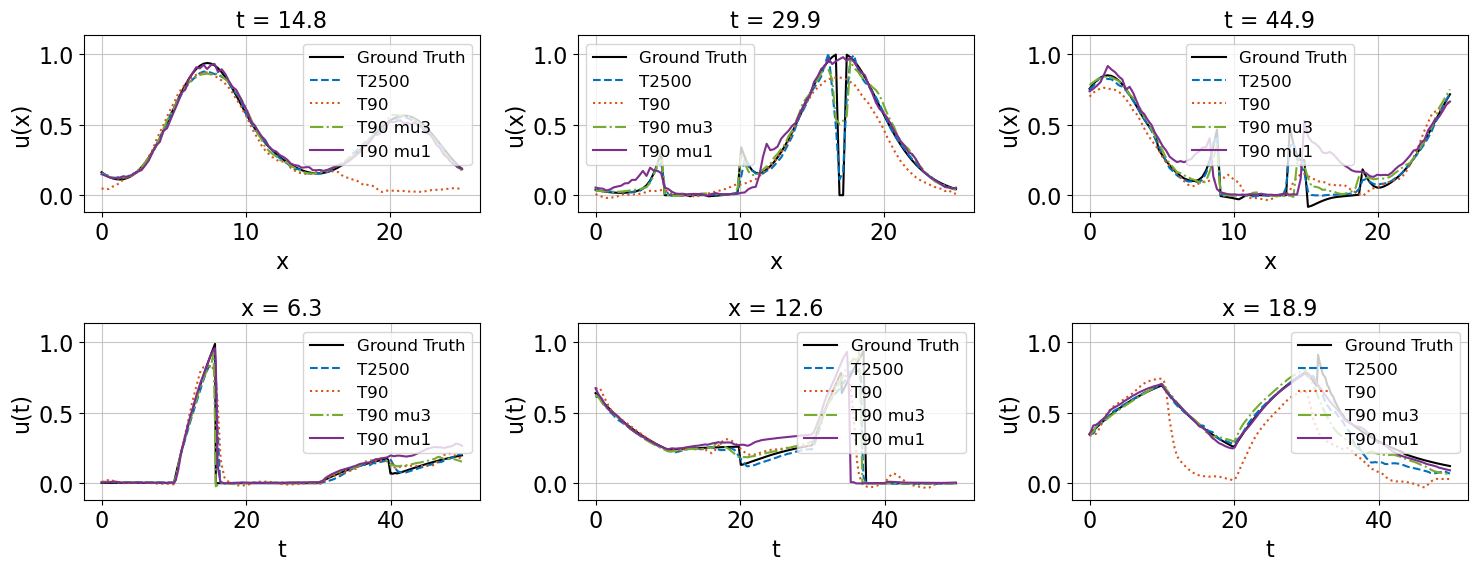

In [99]:
with torch.no_grad():
#     i = 17
    i = 1
    y = torch.tensor(test_data['y'][i])
    x0_feed = test_data['x0'][i]
    t_feed = test_data['t'][i]
    u_feed = test_data['u'][i]
    deltas_feed = test_data['deltas'][i]
    y_pred_T2500, basis_functions = model_T2500(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
    y_pred_T90, basis_functions = model_T100_Scratch(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
    y_pred_T90_mu3, basis_functions = model_T100_oscillatory(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
    y_pred_T90_mu1, basis_functions = model_T100_guassian(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))

    test_loss_trajectory_over_space = torch.abs(y.to(device) - torch.flip(y_pred, dims=[0])).mean(dim=1)  # Or .mean(dim=1) for mean L1
    test_loss_trajectory_over_space_and_time = torch.mean(test_loss_trajectory_over_space)
    print("Lowest trajectory loss: ",test_loss_trajectory_over_space_and_time)
    fig = plot_trajectory_multiple_trajectories(y, [y_pred_T2500,y_pred_T90,y_pred_T90_mu3,y_pred_T90_mu1],t_feed,labels=["Ground Truth", "T2500", "T90", "T90 mu3","T90 mu1"],time_indices=[60, 120,180],space_indices=[25, 50, 75])
#     fig.savefig("oscillatory_mexhat_T90_best.png", dpi=300, bbox_inches='tight')
    plt.show()

## Save to Numpy for plotting

In [101]:
np.savez(
    "plot/data/transfer_learning/mexhat/results_mexhat_1.npz",
    y_pred_T2500=y_pred_T2500.cpu().numpy(),
    y_pred_T90=y_pred_T90.cpu().numpy(),
    y_pred_T90_mu3=y_pred_T90_mu3.cpu().numpy(),
    y_pred_T90_mu1=y_pred_T90_mu1.cpu().numpy(),
    t_feed=t_feed.cpu().numpy(),
    y=y.cpu().numpy()
)

tensor([[49.9200],
        [49.6800],
        [49.4300],
        [49.2400],
        [49.0000],
        [48.5000],
        [48.3100],
        [48.0300],
        [47.8000],
        [47.5100],
        [47.4900],
        [47.1400],
        [46.7900],
        [46.5600],
        [46.4600],
        [46.2300],
        [45.9400],
        [45.5400],
        [45.3600],
        [45.0800],
        [44.8500],
        [44.5200],
        [44.4700],
        [44.1100],
        [43.8400],
        [43.6400],
        [43.4400],
        [43.1500],
        [42.8600],
        [42.5900],
        [42.3100],
        [42.1700],
        [41.7700],
        [41.5700],
        [41.3400],
        [41.2300],
        [40.7600],
        [40.6800],
        [40.2700],
        [40.0300],
        [39.7800],
        [39.5400],
        [39.2900],
        [39.2300],
        [38.7700],
        [38.6600],
        [38.5000],
        [38.0300],
        [37.9200],
        [37.5800],
        [37.4500],
        [37.1700],
        [36.

## Lowest trajectory loss

Lowest trajectory loss:  tensor(0.0110, dtype=torch.float64)


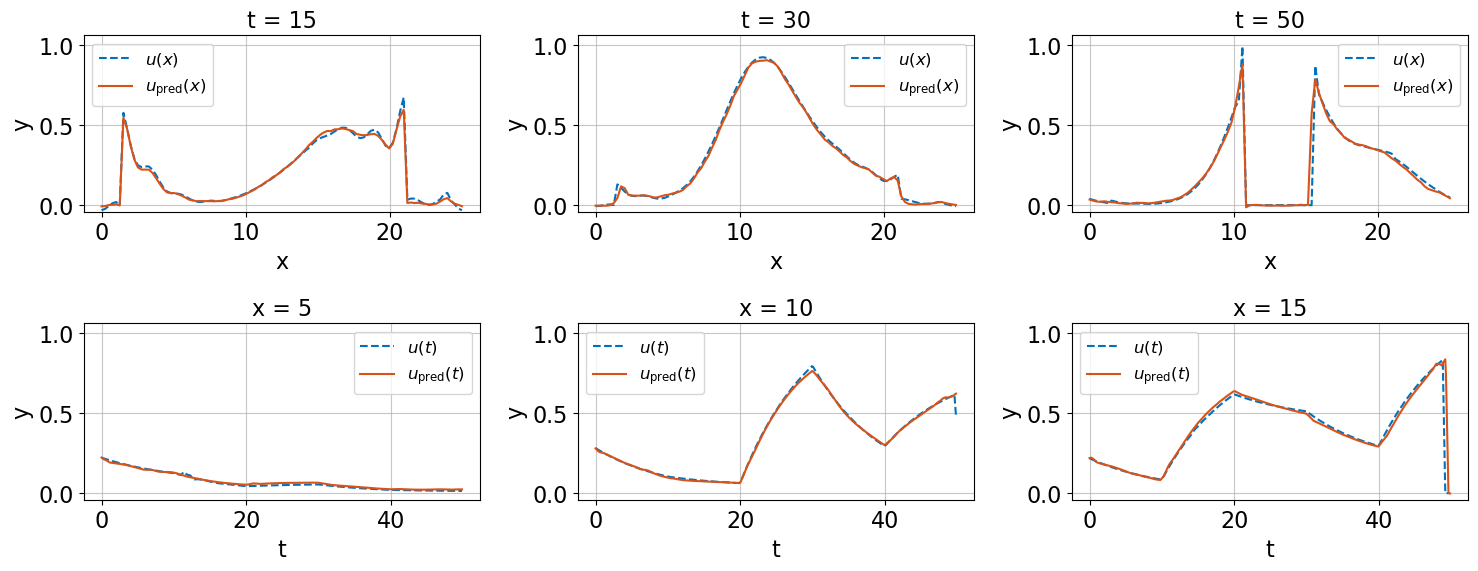

In [11]:
with torch.no_grad():
    i = np.argmin(trajectory_losses)
    y = torch.tensor(test_data['y'][i])
    x0_feed = test_data['x0'][i]
    t_feed = test_data['t'][i]
    u_feed = test_data['u'][i]
    deltas_feed = test_data['deltas'][i]
    y_pred, basis_functions = model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
    test_loss_trajectory_over_space = torch.abs(y.to(device) - torch.flip(y_pred, dims=[0])).mean(dim=1)  # Or .mean(dim=1) for mean L1
    test_loss_trajectory_over_space_and_time = torch.mean(test_loss_trajectory_over_space)
    print("Lowest trajectory loss: ",test_loss_trajectory_over_space_and_time)
    fig = plot_trajectory(y, y_pred,t_feed,time_indices=[60, 120,199],space_indices=[20, 40, 60,])
#     fig.savefig("oscillatory_mexhat_T90_best.png", dpi=300, bbox_inches='tight')
    plt.show()

## Highest trajectory loss

Highest trajectory loss:  tensor(0.0514, dtype=torch.float64)


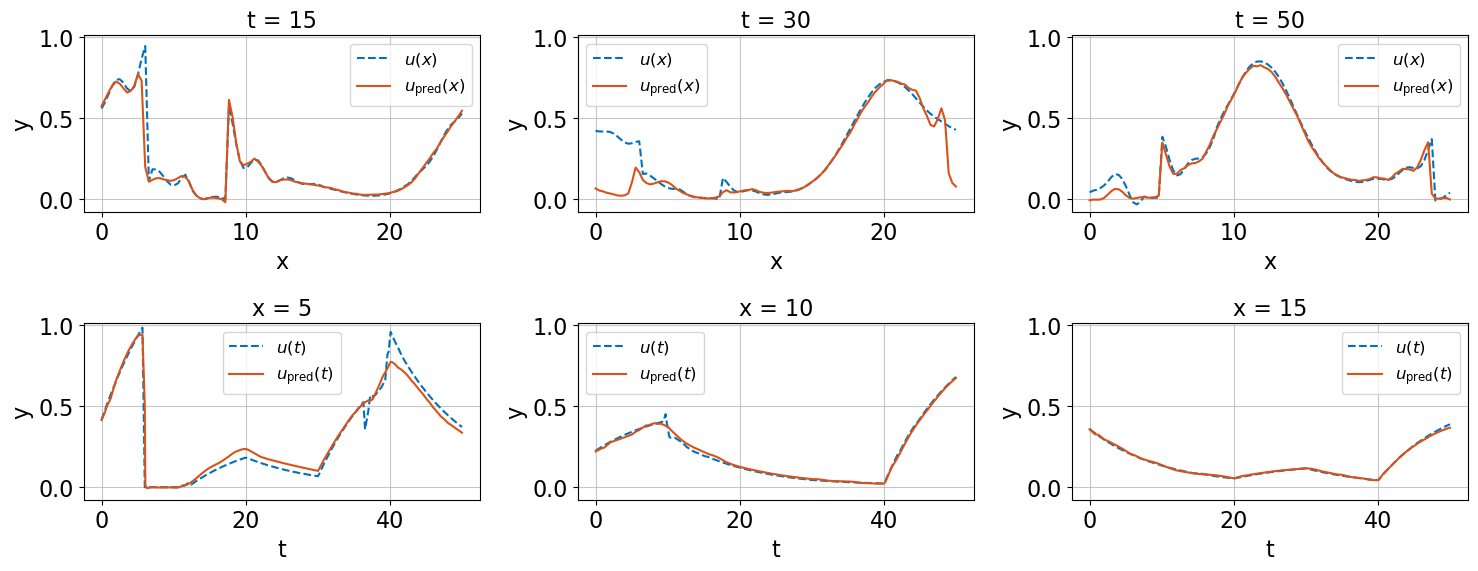

In [10]:
with torch.no_grad():
    i = np.argmax(trajectory_losses)
    y = torch.tensor(test_data['y'][i])
    x0_feed = test_data['x0'][i]
    t_feed = test_data['t'][i]
    u_feed = test_data['u'][i]
    deltas_feed = test_data['deltas'][i]
    y_pred, basis_functions = model(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
    test_loss_trajectory_over_space = torch.abs(y.to(device) - torch.flip(y_pred, dims=[0])).mean(dim=1)  # Or .mean(dim=1) for mean L1
    test_loss_trajectory_over_space_and_time = torch.mean(test_loss_trajectory_over_space)
    print("Highest trajectory loss: ",test_loss_trajectory_over_space_and_time)
    fig = plot_trajectory(y, y_pred,t_feed,time_indices=[60, 120,199],space_indices=[20, 40, 60,])
#     fig.savefig("oscillatory_mexhat_T90_worst.png", dpi=300, bbox_inches='tight')

    plt.show()